In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

# Load CIFAR-10 dataset with only 100 samples per class
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ResNet-18 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

batch_size = 32
learning_rate = 0.001
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


Files already downloaded and verified


In [2]:
class_indices = [[] for _ in range(10)]
count=0
for idx, (_, label) in enumerate(train_dataset):
    if len(class_indices[label]) < 100:
        class_indices[label].append(idx)
        count+=1
    if count==1000:
        break

In [3]:
random_seed = 42
torch.manual_seed(random_seed)

In [4]:
selected_indices = [idx for indices in class_indices for idx in indices]
subset_dataset = torch.utils.data.Subset(train_dataset, selected_indices)
train_loader = torch.utils.data.DataLoader(dataset=subset_dataset, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(subset_dataset))


In [5]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


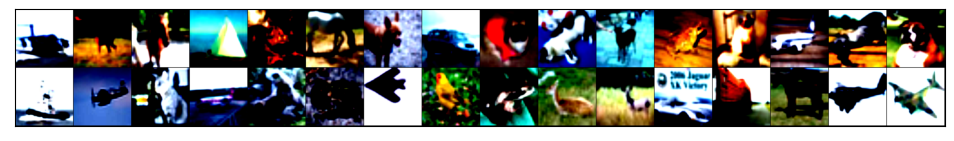

In [6]:
show_batch(train_loader)

In [5]:
# Define the ResNet-18 model
class CifarResNet18(nn.Module):
    def __init__(self):
        super(CifarResNet18, self).__init__()
        self.resnet = resnet18(pretrained=False)  # Initialize ResNet-18 without pretrained weights
        self.resnet.fc = nn.Linear(512, 10)  # Change output layer to have 10 classes

    def forward(self, x):
        return self.resnet(x)

model = CifarResNet18()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


c:\Users\ASUS\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
model = model.to(device)

In [10]:
# Hyperparameters
num_epochs = 42

In [11]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # if (i+1) % 10 == 0:
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%')
    if accuracy==100:
        print("Model is overfit with 100% accuracy on the training dataset.")
        break

print('Training finished.')

Epoch [1/42], Average Loss: 2.3017, Train Accuracy: 18.50%
Epoch [2/42], Average Loss: 1.9127, Train Accuracy: 30.20%
Epoch [3/42], Average Loss: 1.7986, Train Accuracy: 35.30%
Epoch [4/42], Average Loss: 1.7132, Train Accuracy: 38.40%
Epoch [5/42], Average Loss: 1.6326, Train Accuracy: 40.20%
Epoch [6/42], Average Loss: 1.5995, Train Accuracy: 40.80%
Epoch [7/42], Average Loss: 1.4975, Train Accuracy: 44.30%
Epoch [8/42], Average Loss: 1.4301, Train Accuracy: 48.40%
Epoch [9/42], Average Loss: 1.3299, Train Accuracy: 50.20%
Epoch [10/42], Average Loss: 1.2272, Train Accuracy: 55.50%
Epoch [11/42], Average Loss: 1.2131, Train Accuracy: 56.30%
Epoch [12/42], Average Loss: 1.0405, Train Accuracy: 62.20%
Epoch [13/42], Average Loss: 0.9672, Train Accuracy: 65.10%
Epoch [14/42], Average Loss: 0.8813, Train Accuracy: 69.40%
Epoch [15/42], Average Loss: 0.7571, Train Accuracy: 72.70%
Epoch [16/42], Average Loss: 0.6422, Train Accuracy: 79.00%
Epoch [17/42], Average Loss: 0.5634, Train Accura

In [12]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on train images: {}%'.format(100 * correct / total))


Accuracy on train images: 100.0%


In [13]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [14]:
correct_test = 0
total_test = 0
test_loss = 0.0
with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

avg_loss_test = test_loss / len(test_loader)
accuracy_test = 100 * correct_test / total_test

In [15]:
print("Test accuracy: ",accuracy_test,"%", " Test Loss: ",avg_loss_test)

Test accuracy:  46.68 %  Test Loss:  2.2933609097148664


In [16]:
torch.save(model.state_dict(), 'cifar10-resnet18.pth')

**Magnitude of Kernels at different Layers**

Layer: resnet.conv1.weight, Magnitude: 2.9158
torch.Size([64, 3, 7, 7])
Layer: resnet.layer1.0.conv1.weight, Magnitude: 11.8240
torch.Size([64, 64, 3, 3])
Layer: resnet.layer1.0.conv2.weight, Magnitude: 11.8883
torch.Size([64, 64, 3, 3])
Layer: resnet.layer1.1.conv1.weight, Magnitude: 11.8302
torch.Size([64, 64, 3, 3])
Layer: resnet.layer1.1.conv2.weight, Magnitude: 11.9900
torch.Size([64, 64, 3, 3])
Layer: resnet.layer2.0.conv1.weight, Magnitude: 12.2055
torch.Size([128, 64, 3, 3])
Layer: resnet.layer2.0.conv2.weight, Magnitude: 17.6431
torch.Size([128, 128, 3, 3])
Layer: resnet.layer2.1.conv1.weight, Magnitude: 17.5288
torch.Size([128, 128, 3, 3])
Layer: resnet.layer2.1.conv2.weight, Magnitude: 17.9350
torch.Size([128, 128, 3, 3])
Layer: resnet.layer3.0.conv1.weight, Magnitude: 19.3495
torch.Size([256, 128, 3, 3])
Layer: resnet.layer3.0.conv2.weight, Magnitude: 28.4731
torch.Size([256, 256, 3, 3])
Layer: resnet.layer3.1.conv1.weight, Magnitude: 27.8162
torch.Size([256, 256, 3, 3])
La

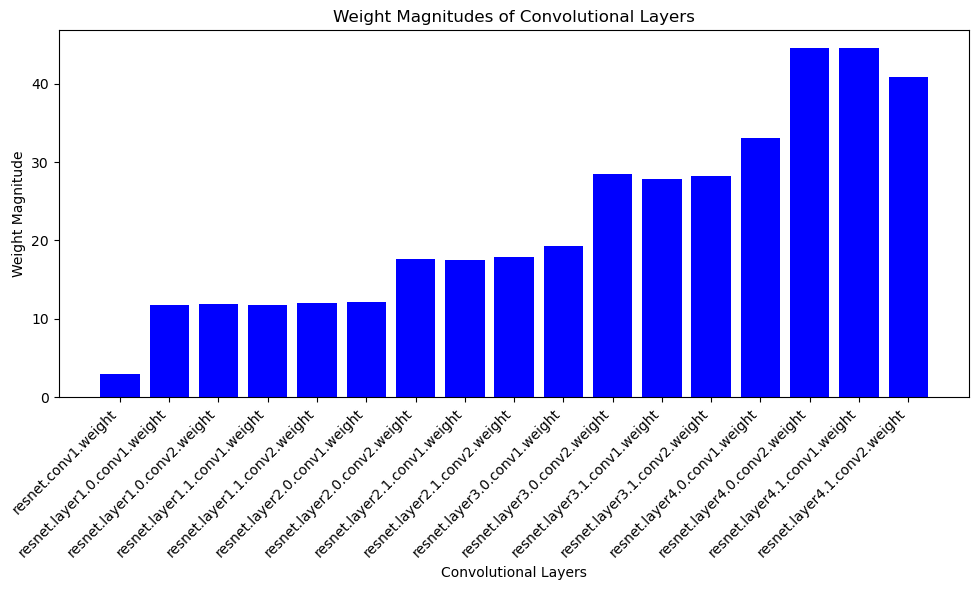

In [17]:
magnitudes = []  # To store magnitudes of weights
layer_names = []  # To store layer names

for name, param in model.named_parameters():
    if 'weight' in name and 'conv' in name:
        magnitude = torch.norm(param.data).cpu().numpy()
        print(f'Layer: {name}, Magnitude: {magnitude:.4f}')
        print(param.data.shape)
        magnitudes.append(magnitude)
        layer_names.append(name)
        # print(param.data)

plt.figure(figsize=(10, 6))
plt.bar(layer_names, magnitudes, color='blue')
plt.xlabel('Convolutional Layers')
plt.ylabel('Weight Magnitude')
plt.title('Weight Magnitudes of Convolutional Layers')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

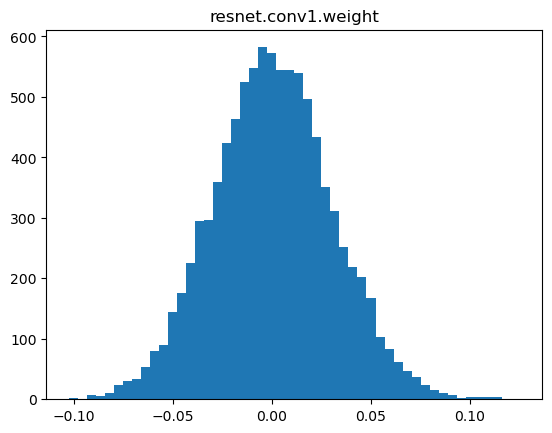

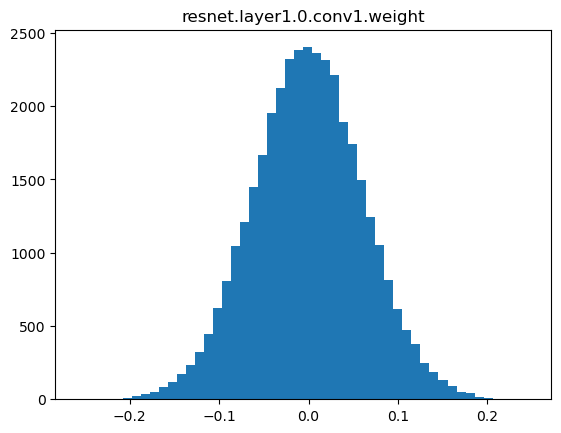

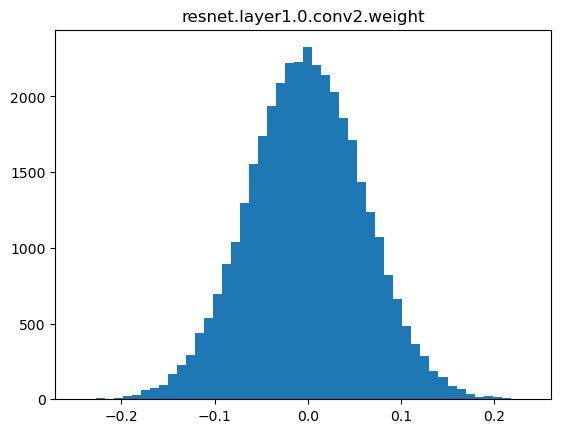

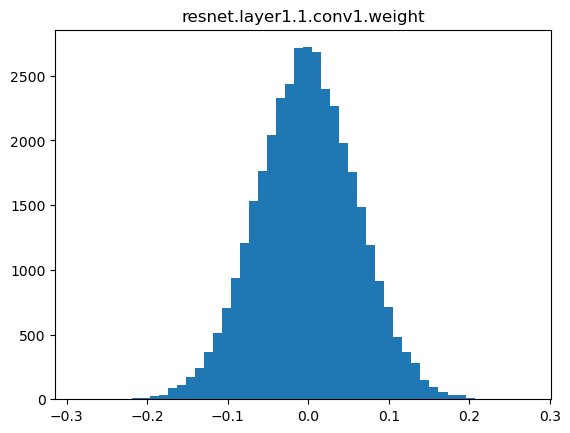

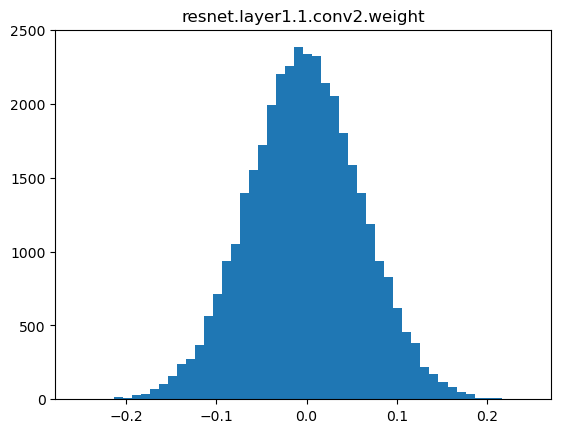

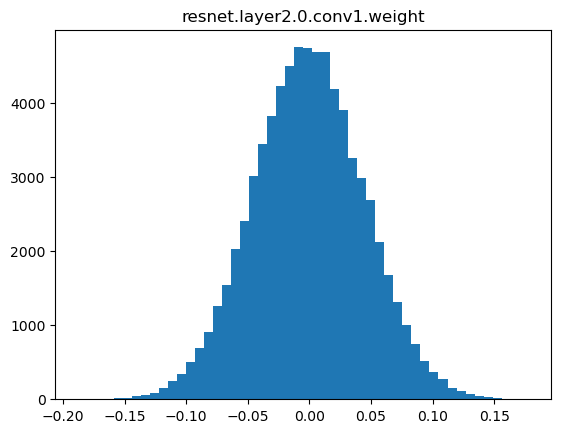

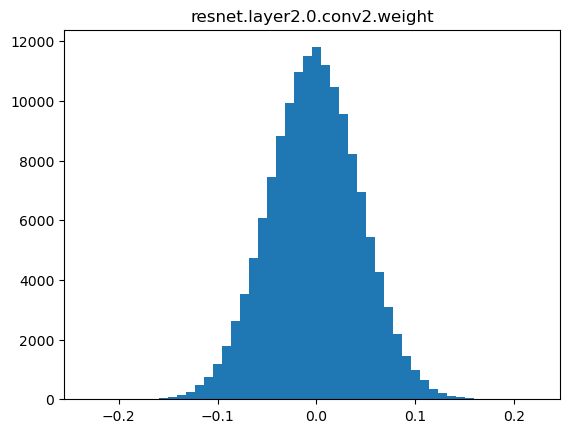

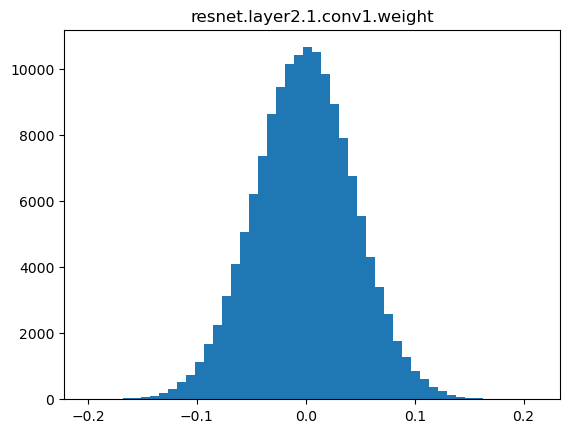

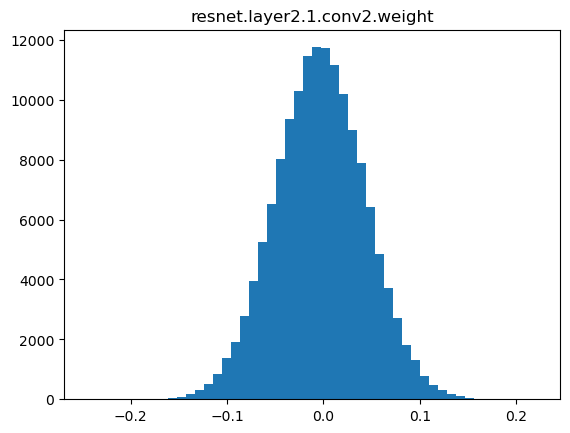

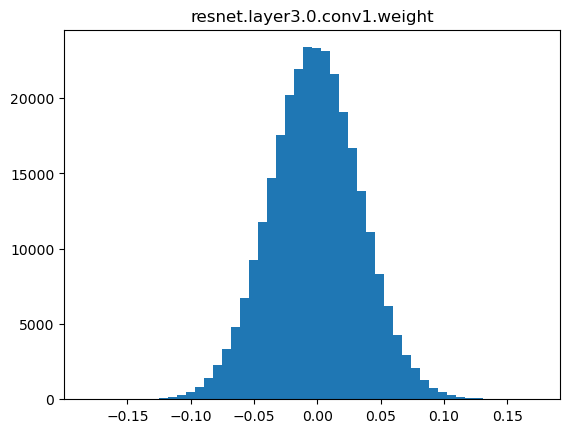

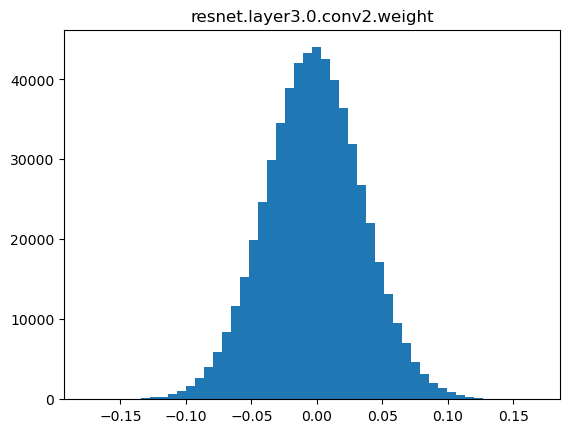

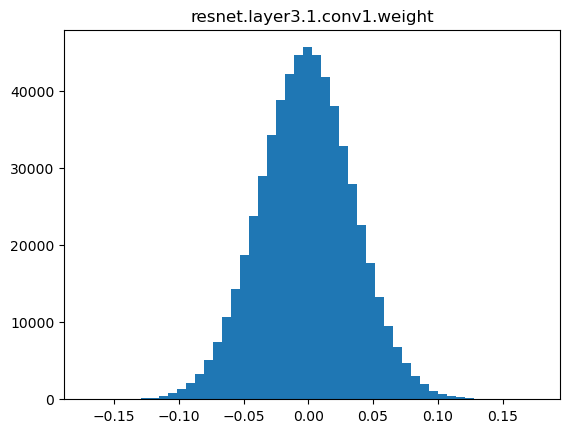

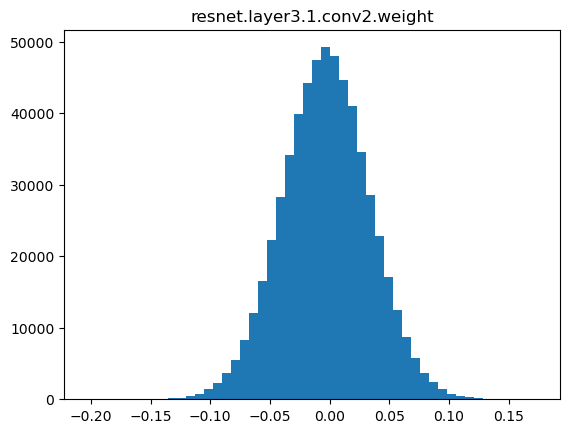

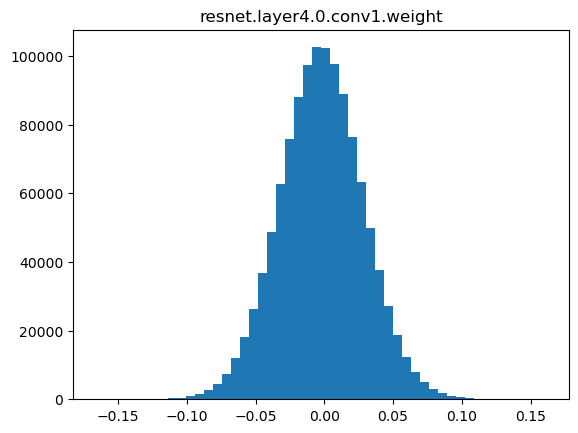

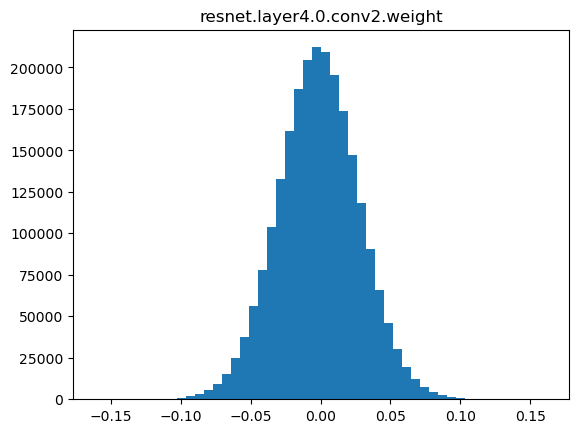

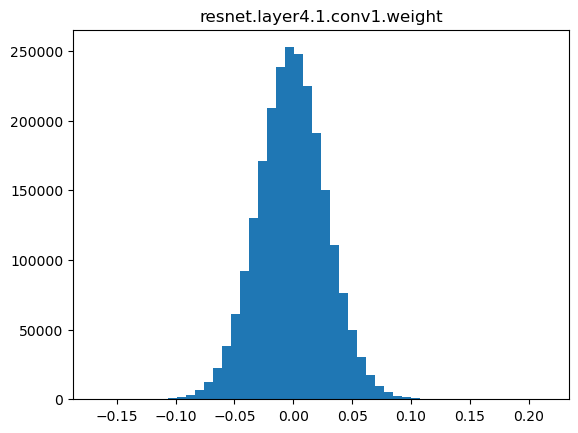

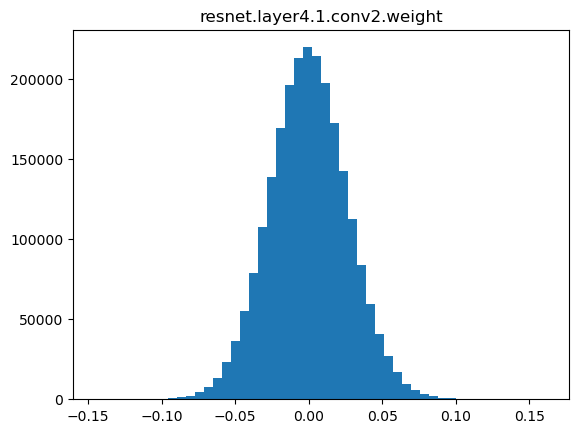

In [18]:

def visualize_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name and 'conv' in name:
            plt.hist(param.data.cpu().numpy().flatten(), bins=50)
            plt.title(name)
            plt.show()

# Visualize the weights
visualize_weights(model)

In [ ]:
# model = CifarResNet18()
# model.load_state_dict(torch.load("cifar10-resnet18.pth"))

c:\Users\ASUS\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

**Visualization of Kernels at different Layers**

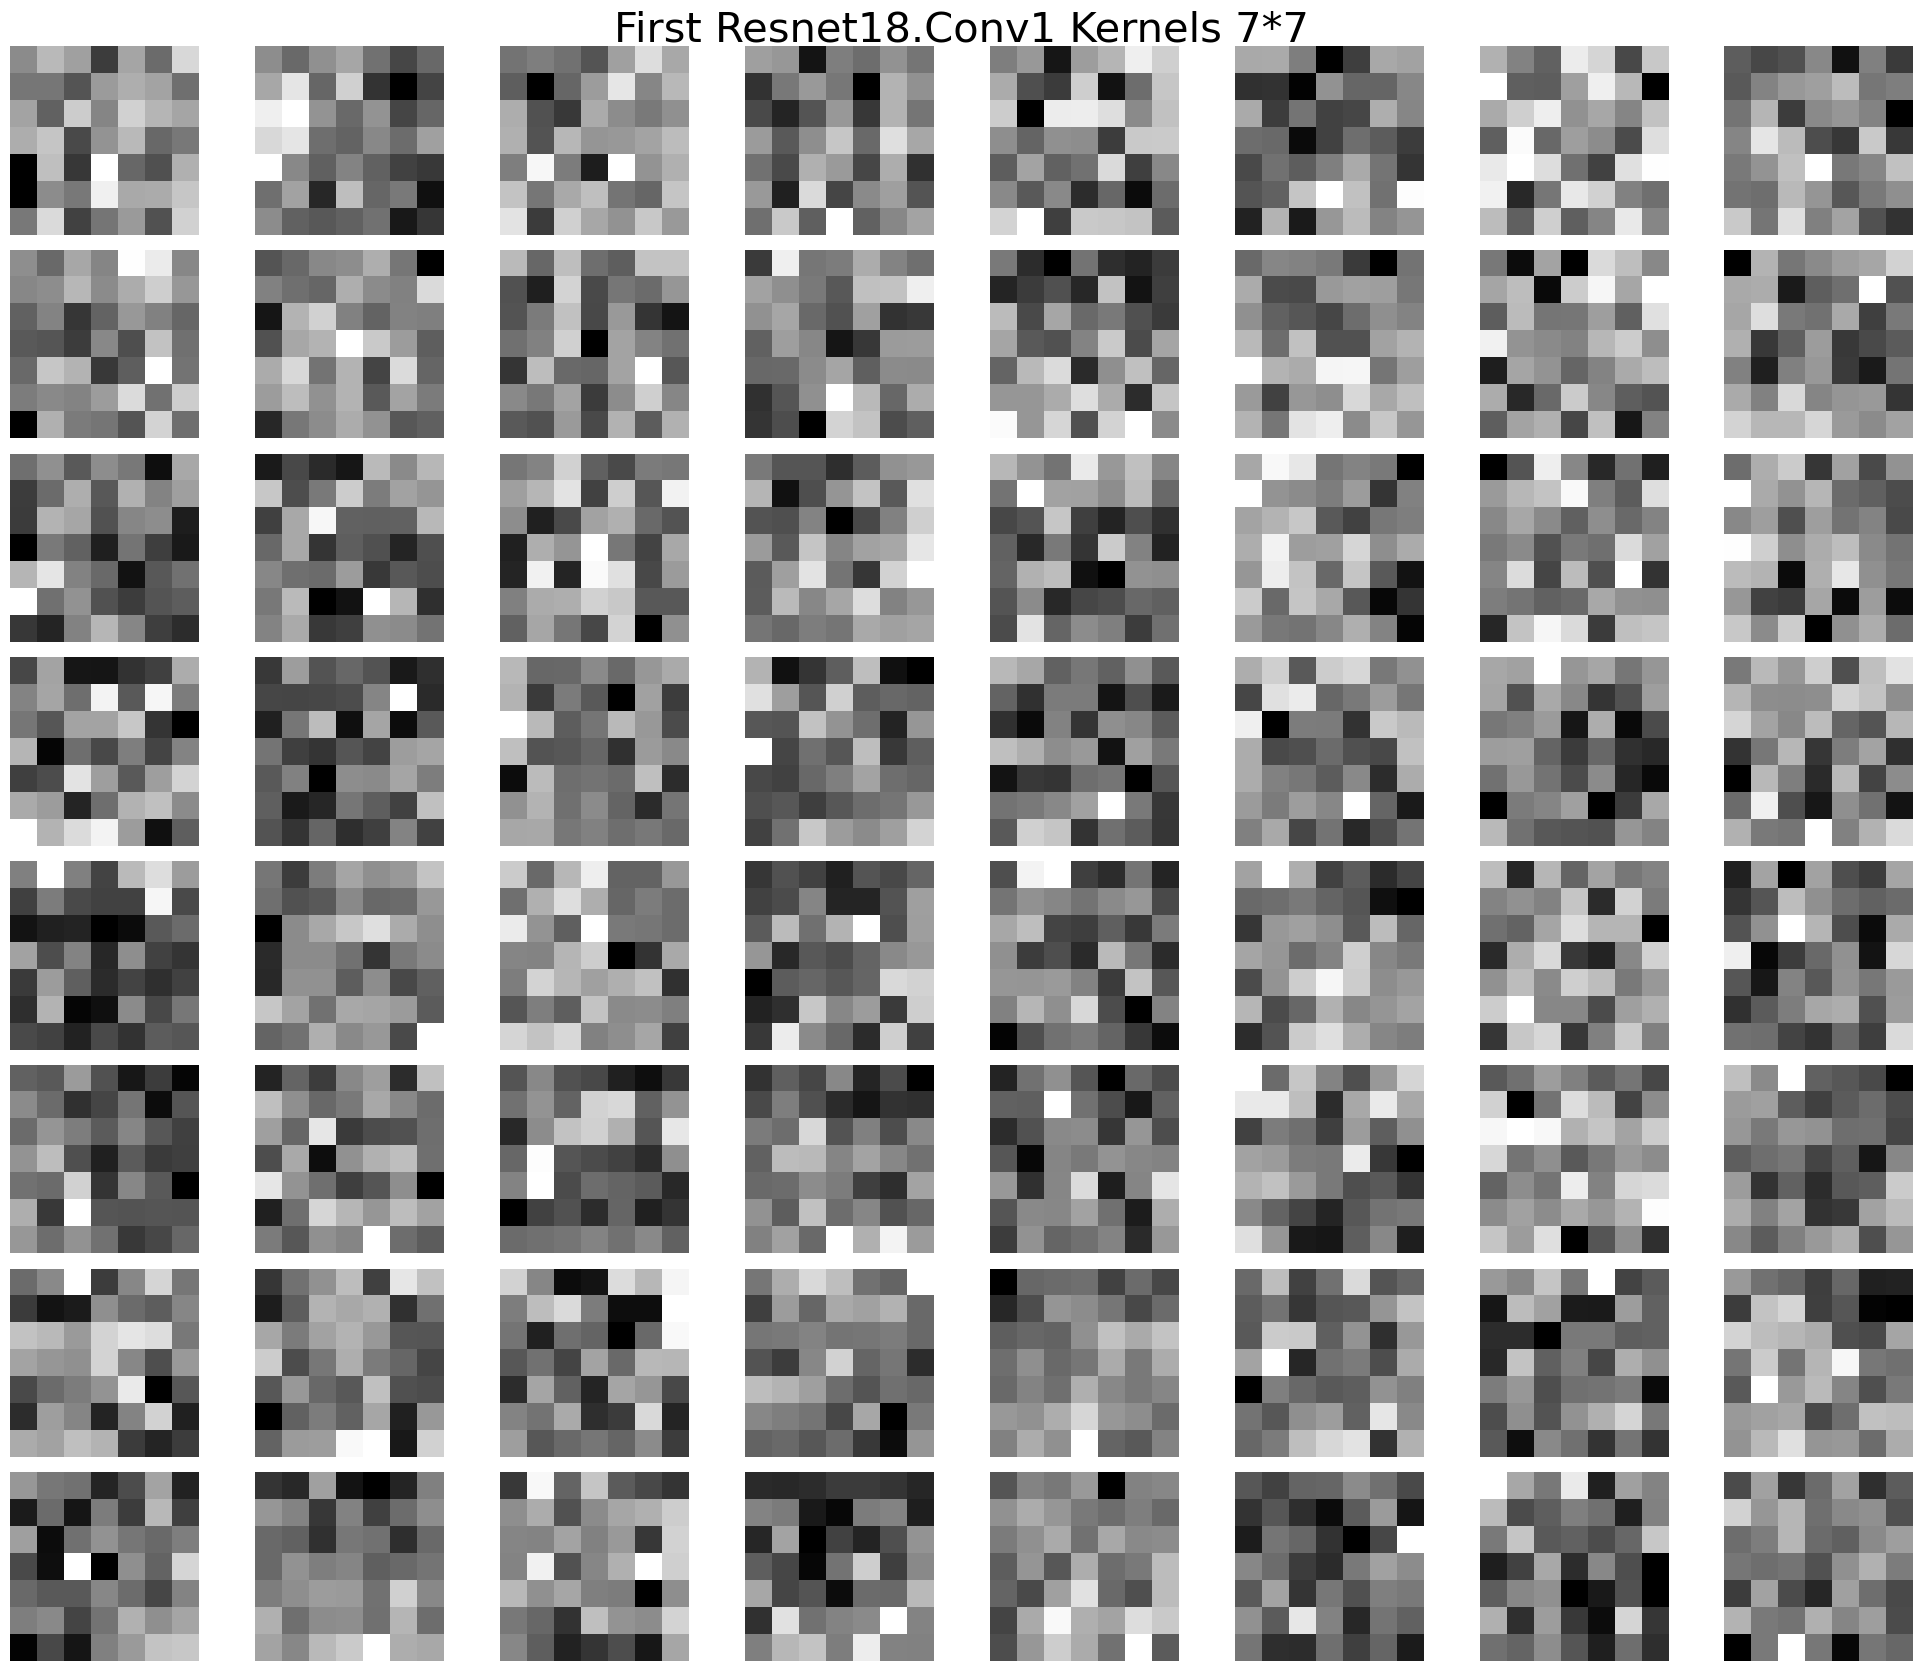

In [58]:
import matplotlib.pyplot as plt
import numpy as np

conv1_weight = model.resnet.conv1.weight.data

# Visualize the kernels in the first convolutional layer
num_kernels = conv1_weight.size(0)
kernel_size = conv1_weight.size(1)
rows = int(np.sqrt(num_kernels))
cols = num_kernels // rows

fig, axs = plt.subplots(rows, cols, figsize=(20, 17))

for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        kernel = conv1_weight[index].cpu().numpy()
        axs[i, j].imshow(kernel[0,:,:],cmap='gray')
        axs[i, j].axis('off')

plt.suptitle('First Resnet18.Conv1 Kernels 7*7', fontsize=30)
plt.tight_layout()
plt.show()

visulization of all the kernels at different layers

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  64


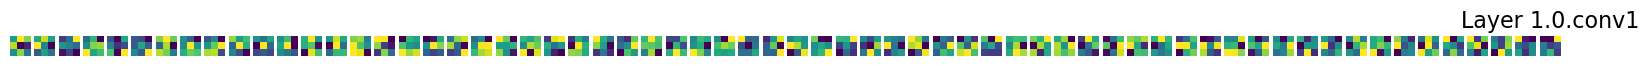

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  64


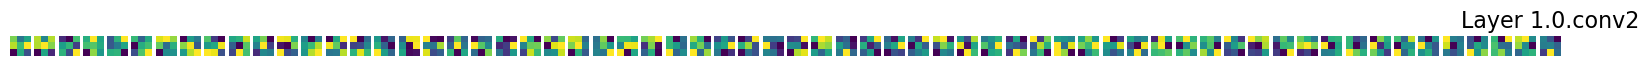

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  64


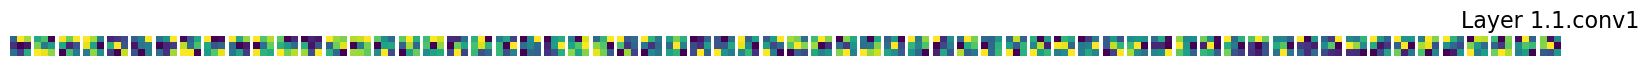

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  64


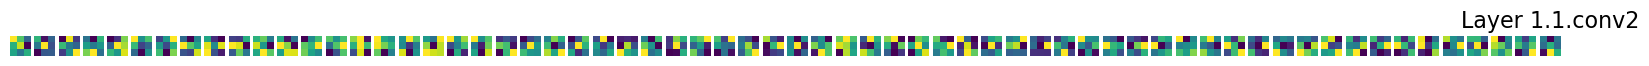

Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
num_kernels:  128


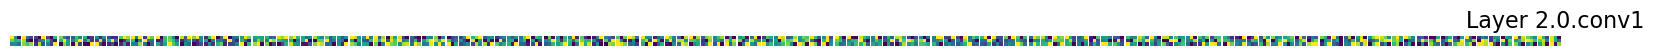

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  128


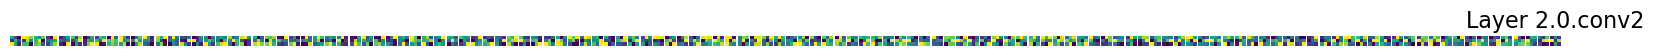

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  128


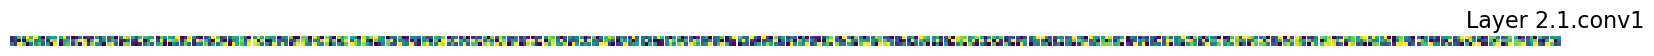

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  128


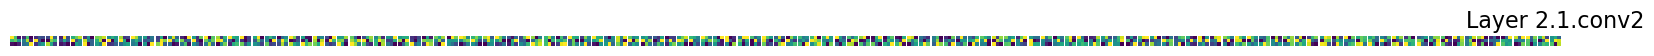

Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
num_kernels:  256


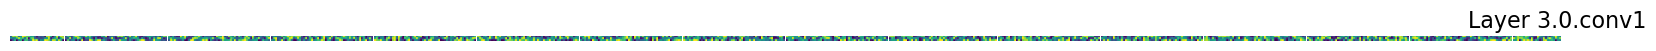

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  256


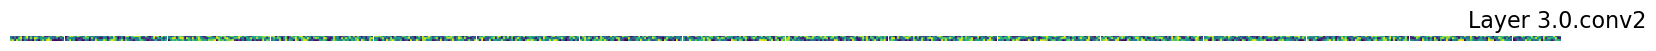

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  256


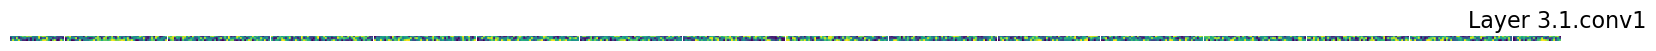

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  256


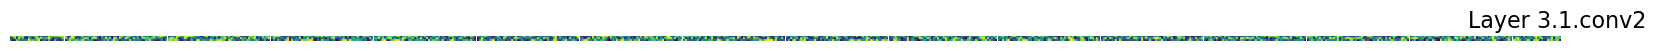

Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
num_kernels:  512


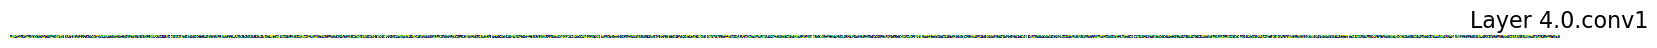

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  512


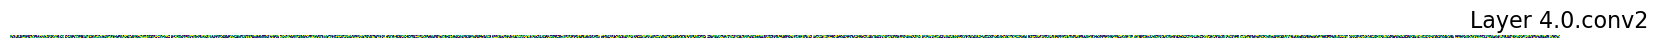

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  512


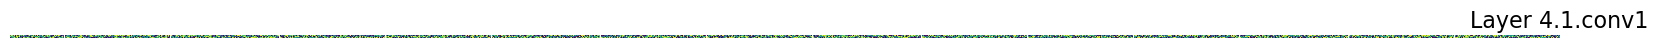

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_kernels:  512


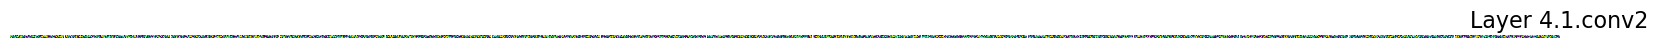

In [56]:
target_layers = []
for layer in [model.resnet.layer1, model.resnet.layer2, model.resnet.layer3, model.resnet.layer4]:
    target_layers.extend([sub_layer.conv1, sub_layer.conv2] for sub_layer in layer)

# Visualize kernels
for layer_idx, layer in enumerate(target_layers):
    # print(len(layer))
    for kernel_idx, conv_layer in enumerate(layer):
        if isinstance(conv_layer, nn.Conv2d):
            print(conv_layer)
            weight_tensor = conv_layer.weight.data.clone()
            num_kernels = weight_tensor.size(0)

            fig, axs = plt.subplots(1, num_kernels, figsize=(20, 2))
            print("num_kernels: ",num_kernels)
            for i in range(num_kernels):
                kernel = weight_tensor[i].cpu().numpy()
                #we will show first filter of every kernel
                axs[i].imshow(kernel[0], cmap='viridis')
                axs[i].axis('off')

            # plt.title(f"Layer {layer_idx + 1}, Kernel {kernel_idx + 1}")
            if (layer_idx+1)%2 == 0:
                ind = 1
            else:
                ind= 0
            plt.title(f"Layer {(layer_idx)//2+1}.{ind}.conv{kernel_idx+1}", fontsize=16)
            plt.show()

Visulization of 64 random kernel at different layers (For better visulization we took only 64 here) 

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


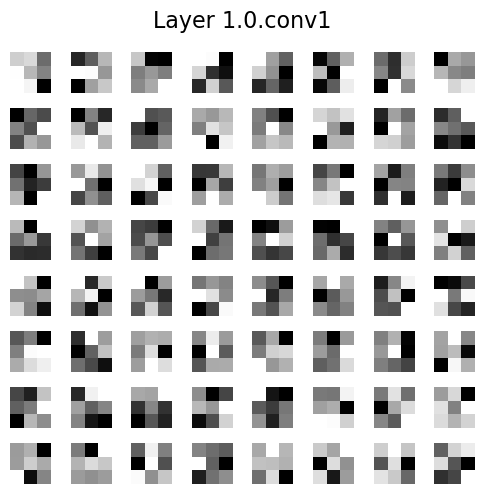

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


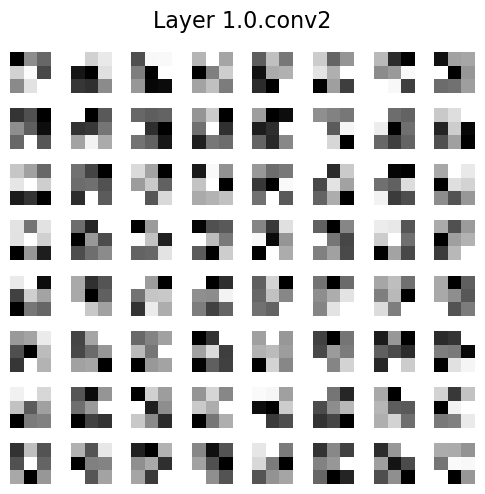

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


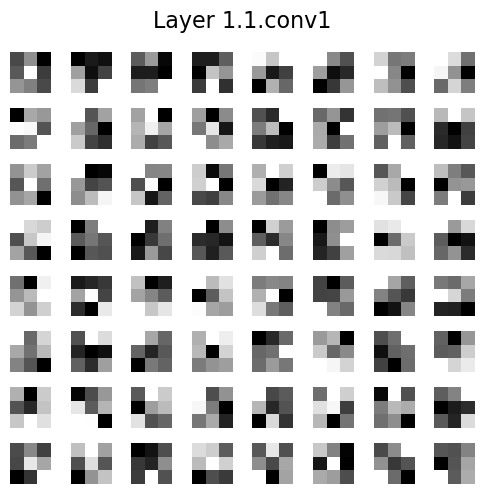

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


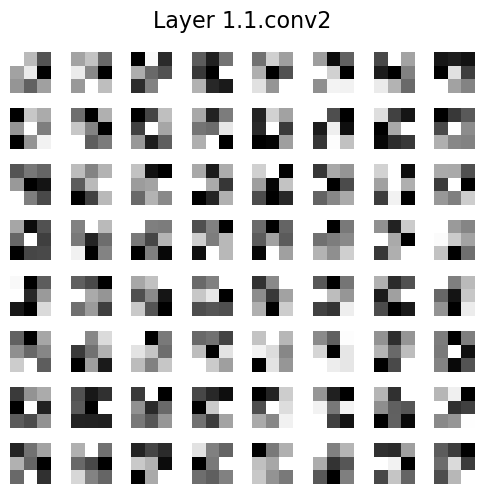

Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


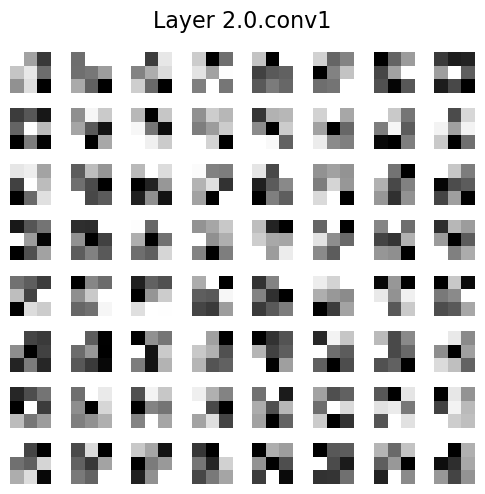

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


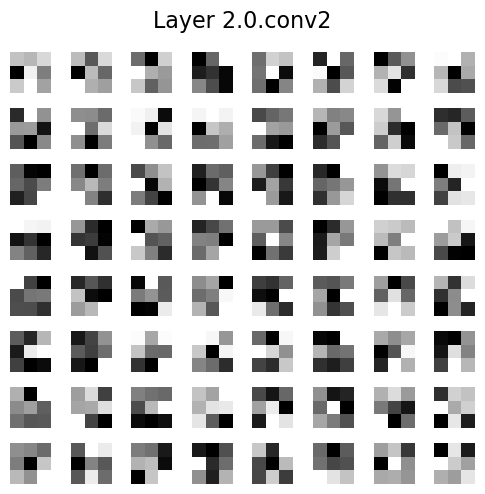

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


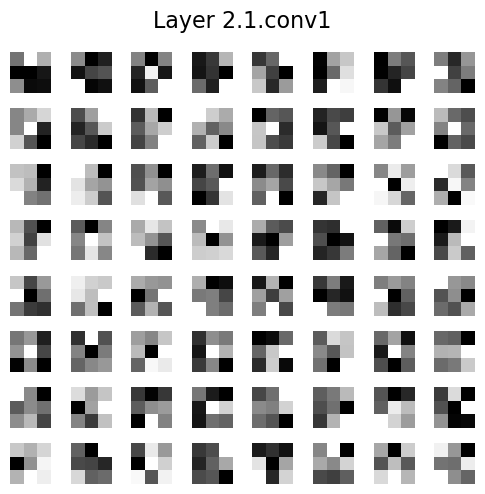

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


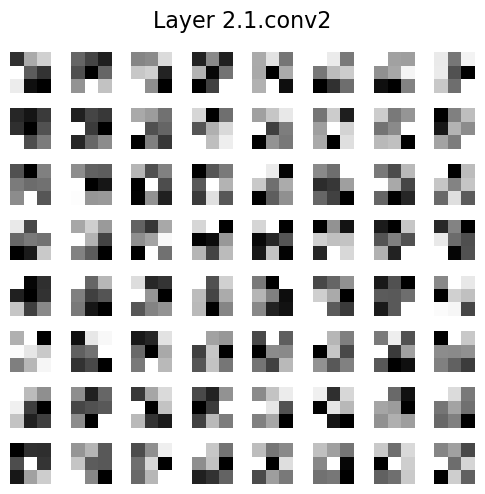

Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


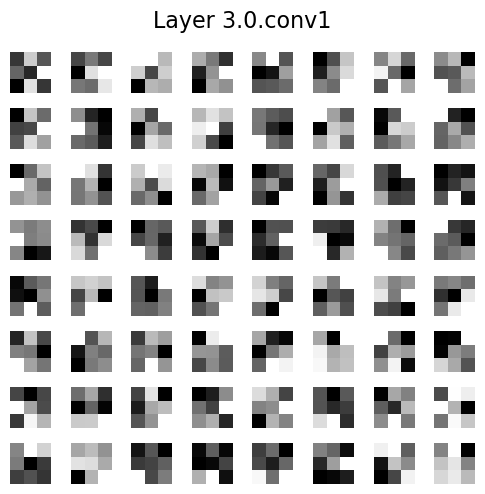

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


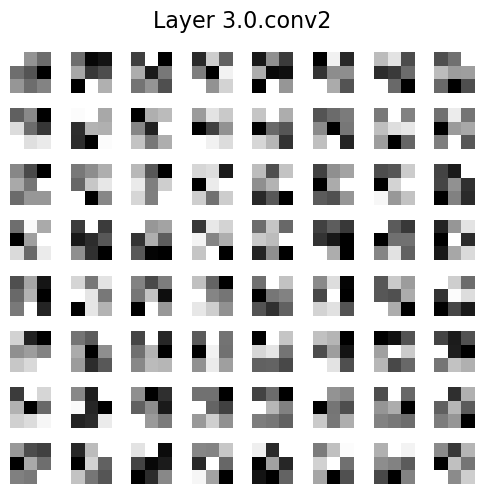

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


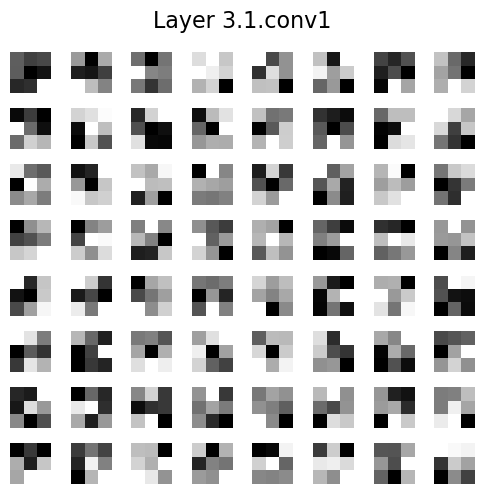

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


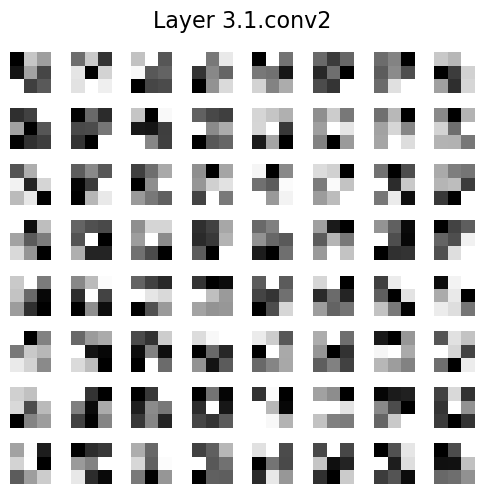

Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


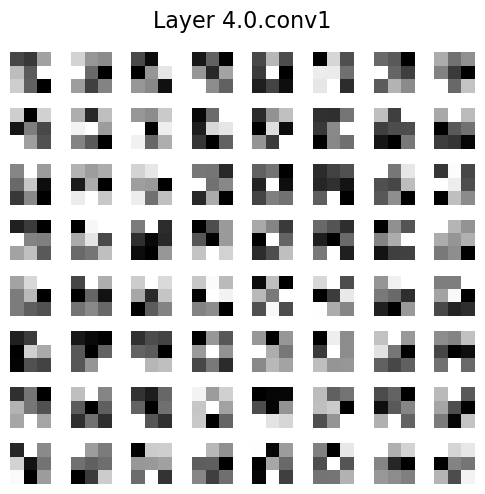

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


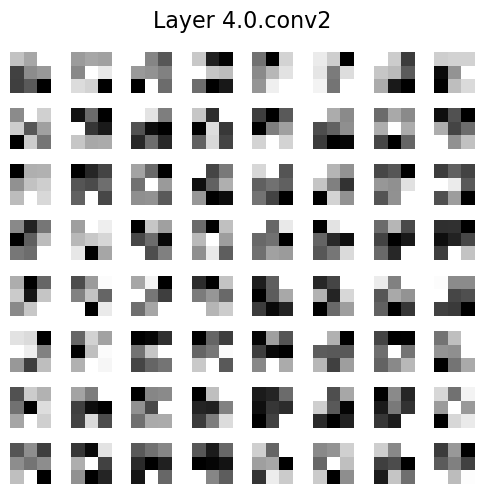

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


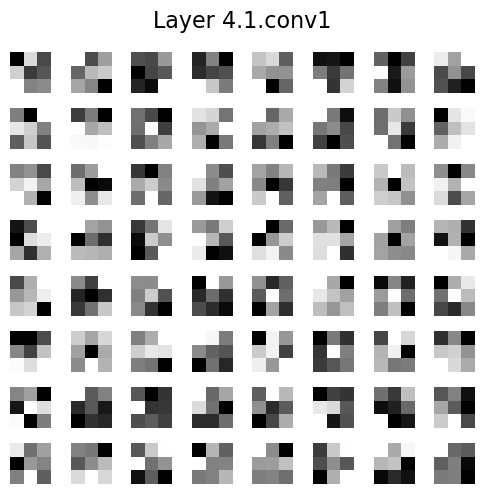

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


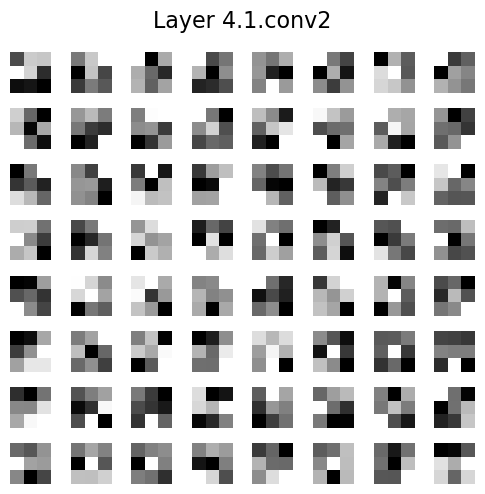

In [55]:
import random 
# Define the number of kernels to visualize for each layer
num_kernels_to_visualize = 64

# Define the layers you want to visualize
target_layers = []
for layer in [model.resnet.layer1, model.resnet.layer2, model.resnet.layer3, model.resnet.layer4]:
    target_layers.extend([sub_layer.conv1, sub_layer.conv2] for sub_layer in layer)

# Visualize kernels
for layer_idx, layer in enumerate(target_layers):
    for kernel_idx, conv_layer in enumerate(layer):
        if isinstance(conv_layer, nn.Conv2d):
            print(conv_layer)
            weight_tensor = conv_layer.weight.data.clone()
            num_kernels = weight_tensor.size(0)

            # Randomly select a subset of kernels to visualize
            selected_kernel_indices = random.sample(range(num_kernels), min(num_kernels_to_visualize, num_kernels))

            fig, axs = plt.subplots(8, 8, figsize=(5, 5))

            for i, ax in enumerate(axs.flat):
                if i < len(selected_kernel_indices):
                    kernel_index = selected_kernel_indices[i]
                    kernel = weight_tensor[kernel_index].cpu().numpy()
                    ax.imshow(kernel[0], cmap='gray')
                    ax.axis('off')

            if (layer_idx+1)%2 == 0:
                ind = 1
            else:
                ind= 0
            plt.suptitle(f"Layer {(layer_idx)//2+1}.{ind}.conv{kernel_idx+1}", fontsize=16)
            plt.tight_layout()
            plt.show()

**[Additional] Feature Map of Horse Image at different Layer**

In [19]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  7
Class:  horse


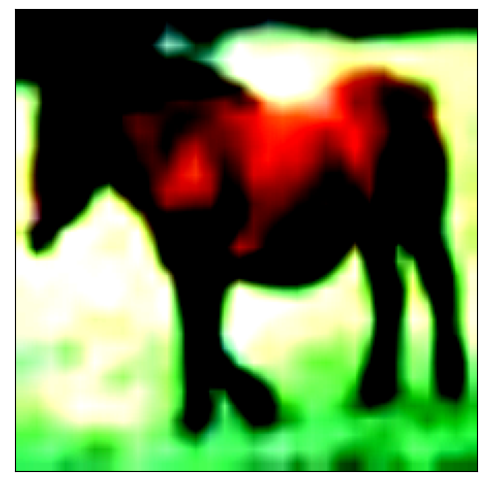

In [22]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

horse = []

for image,label in subset_dataset:
    if label==7:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
        print("Label: ",label)
        print("Class: ",train_dataset.classes[label])
        horse = image
        break
    # print(image)

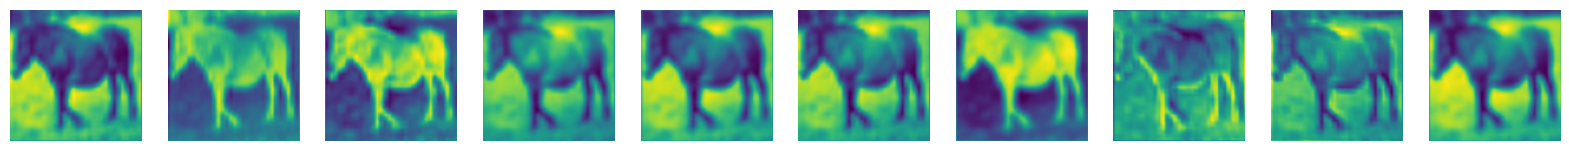

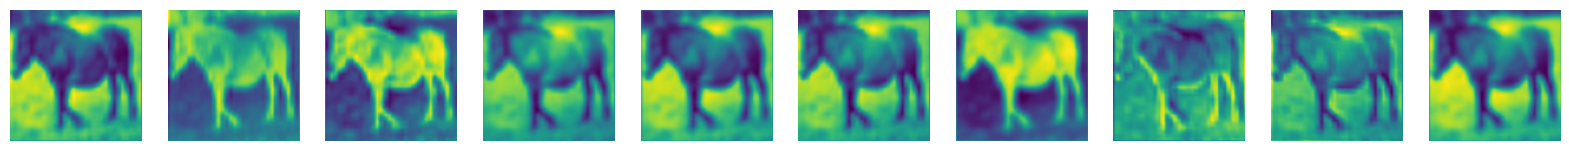

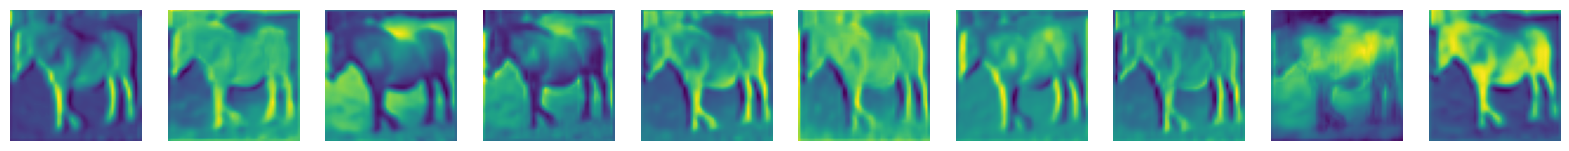

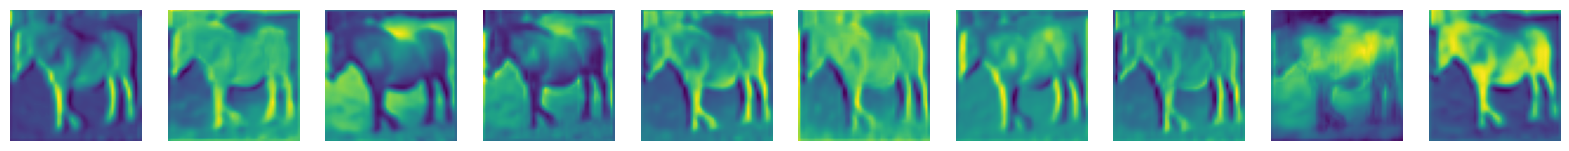

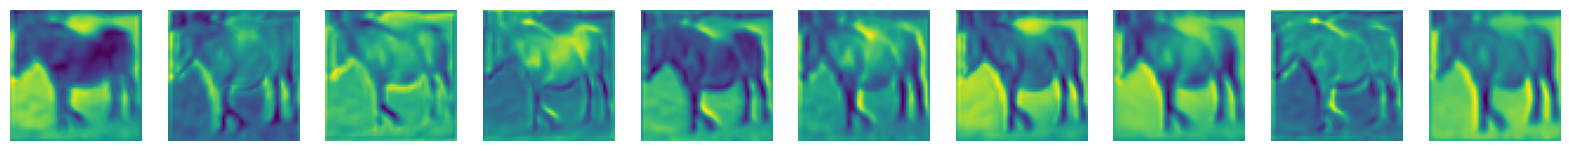

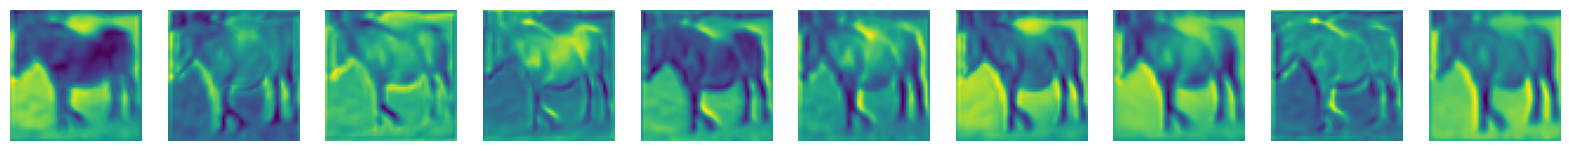

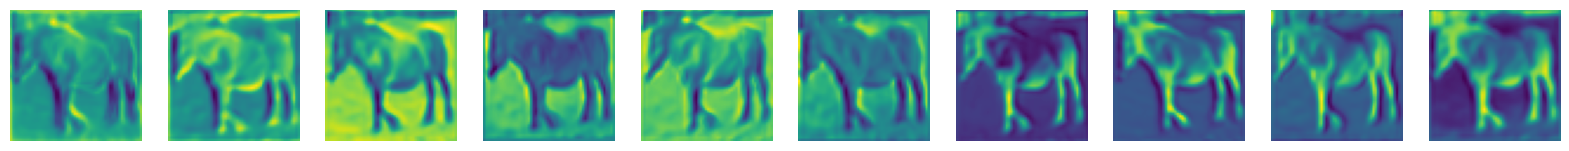

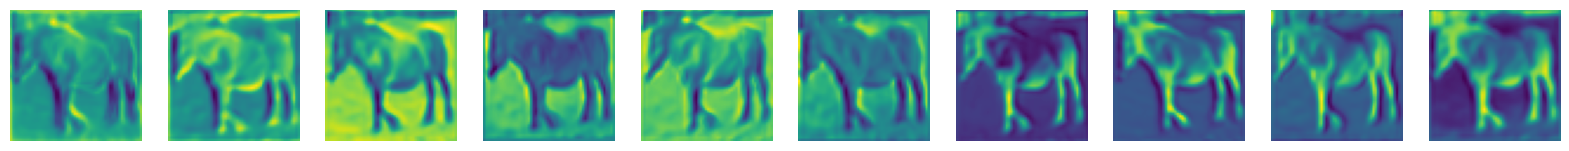

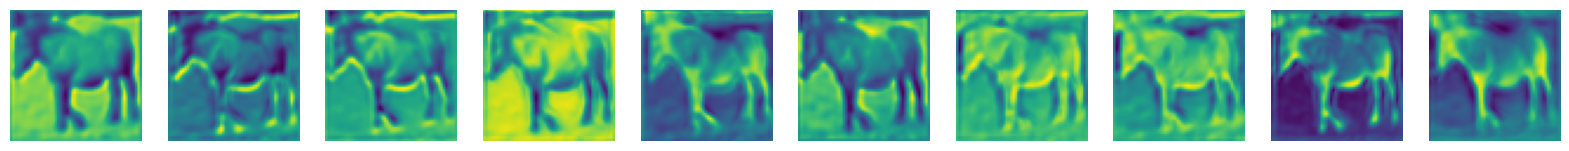

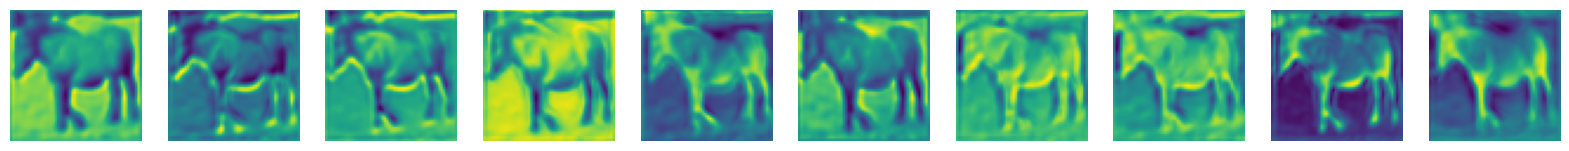

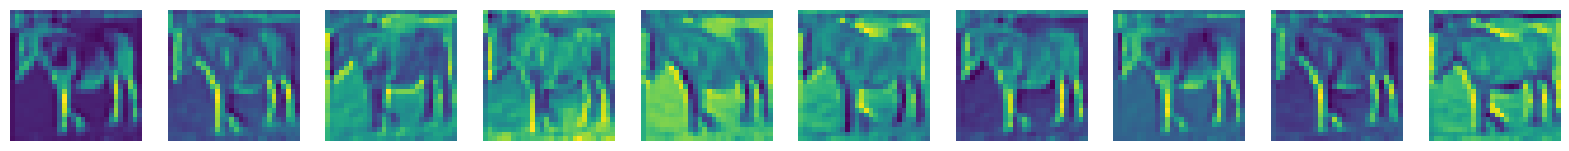

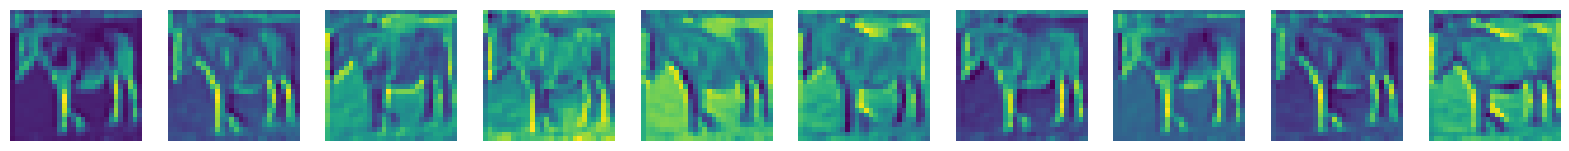

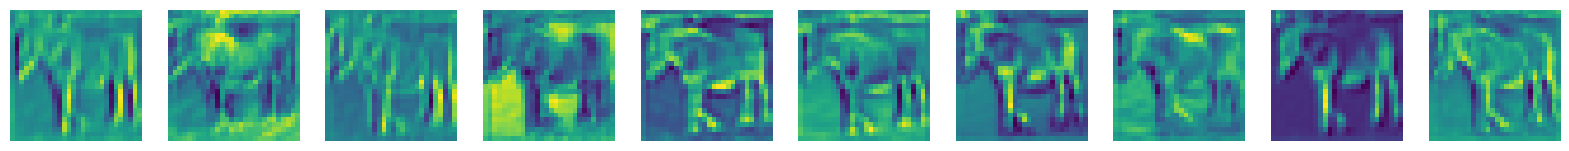

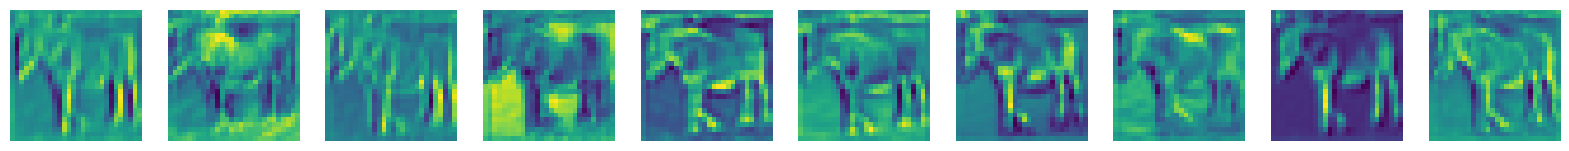

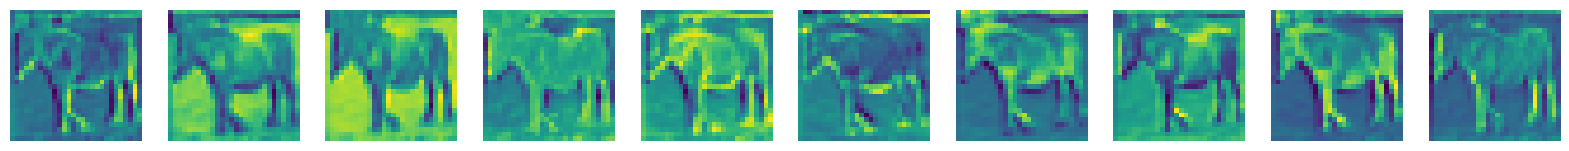

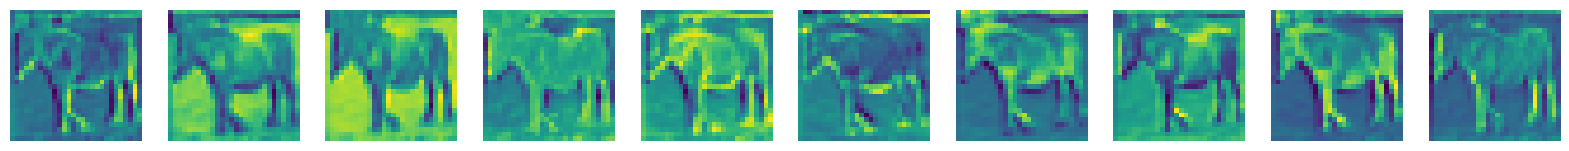

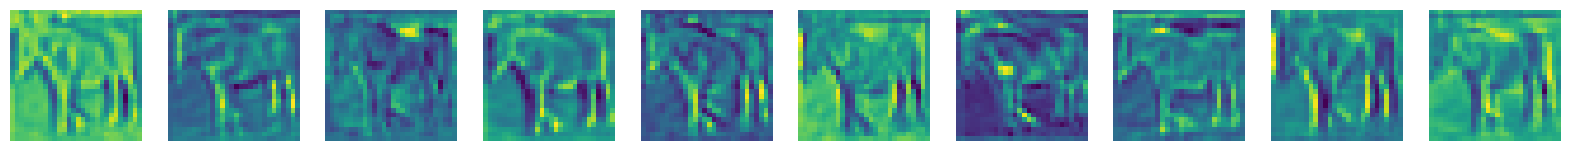

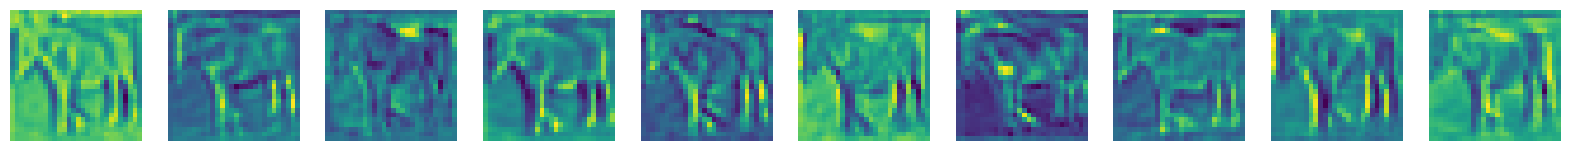

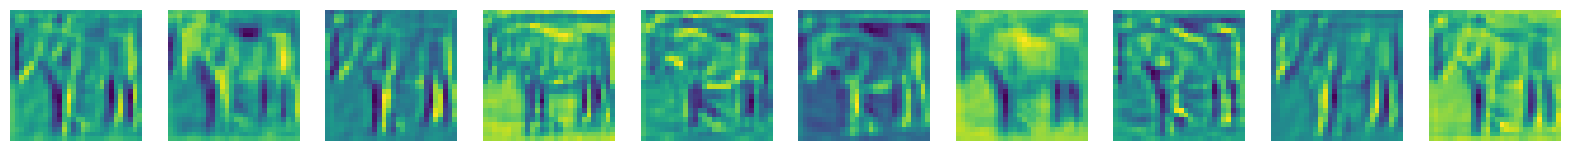

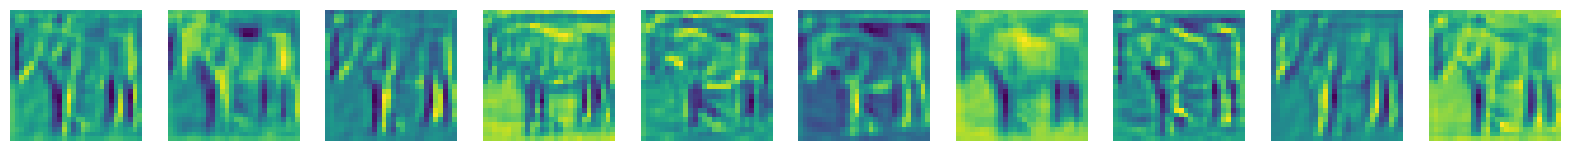

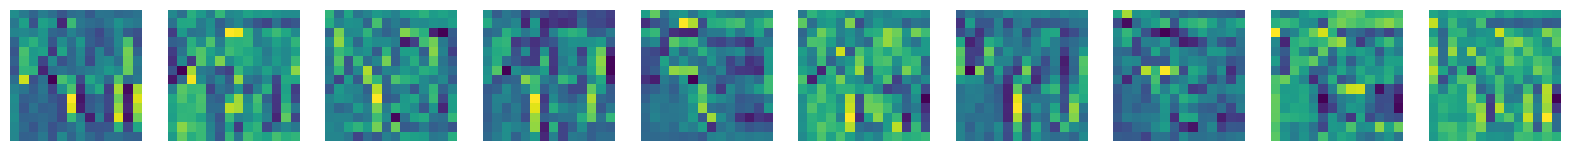

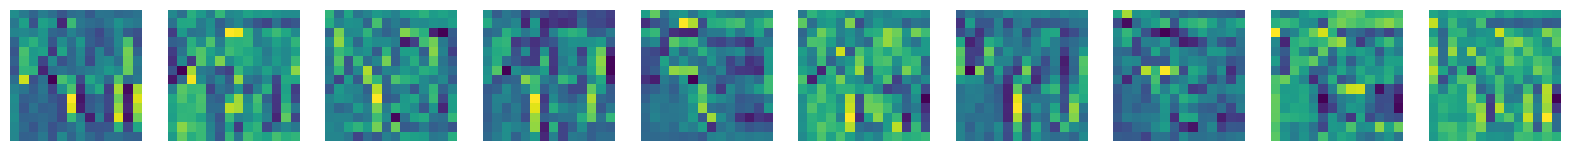

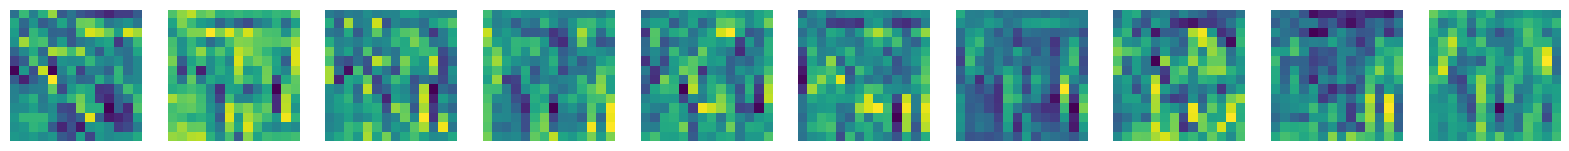

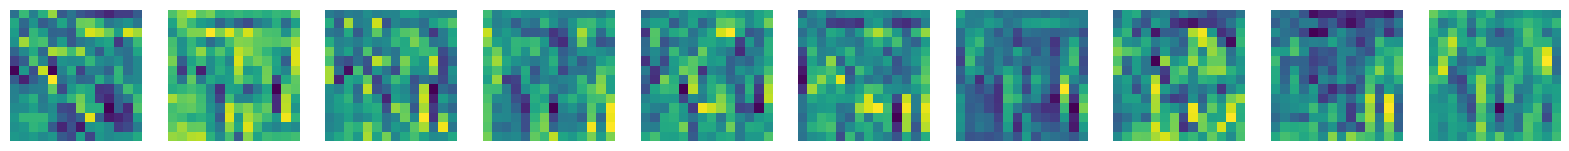

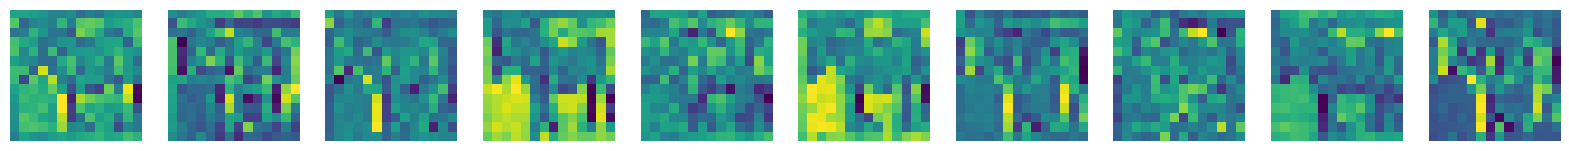

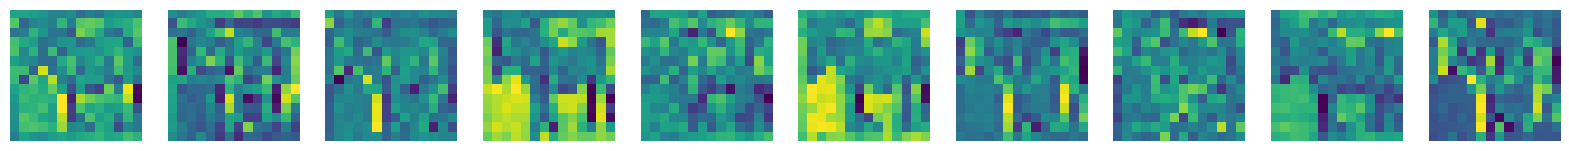

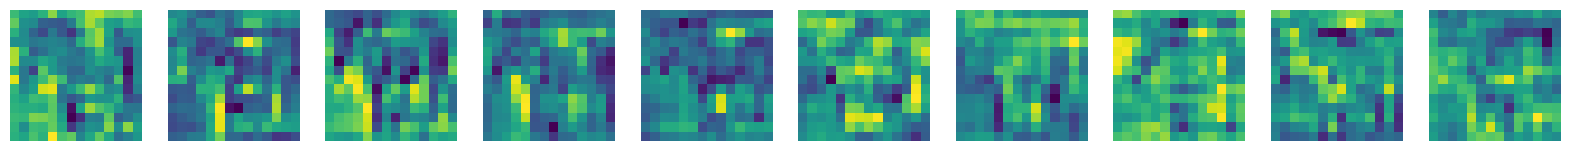

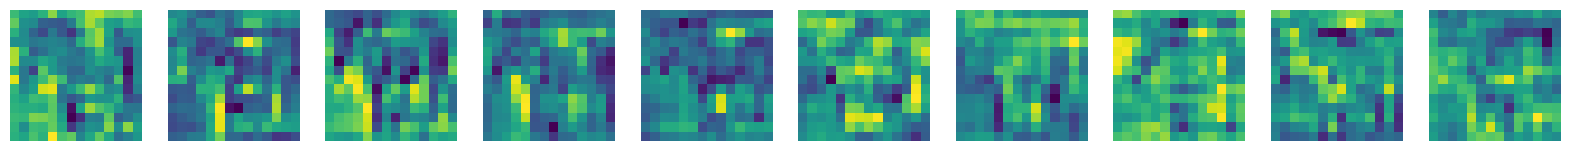

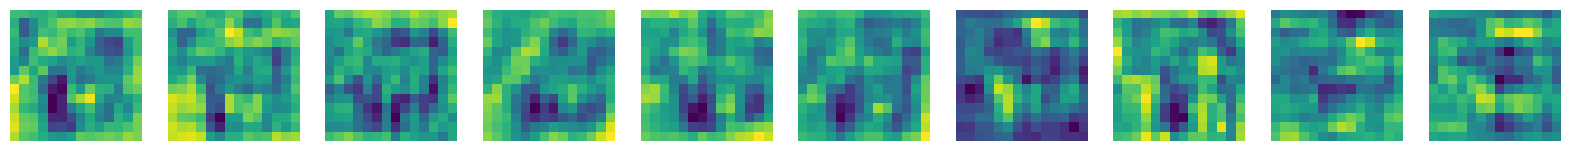

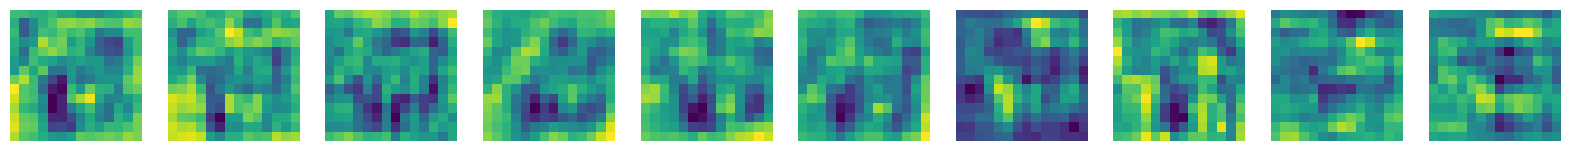

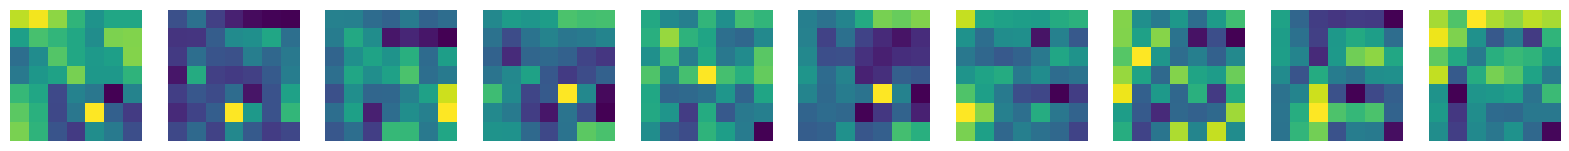

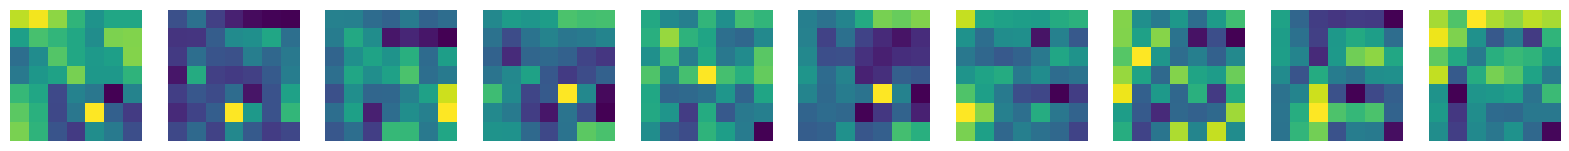

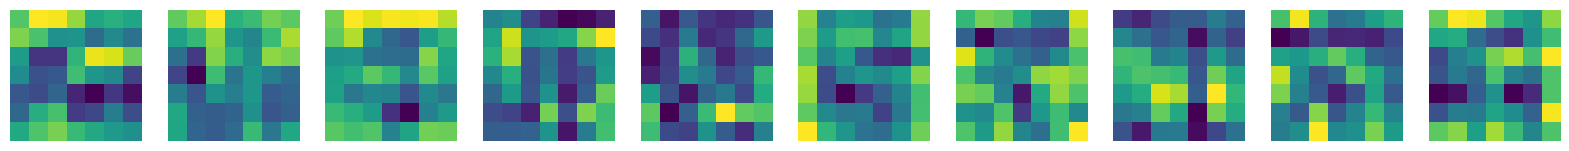

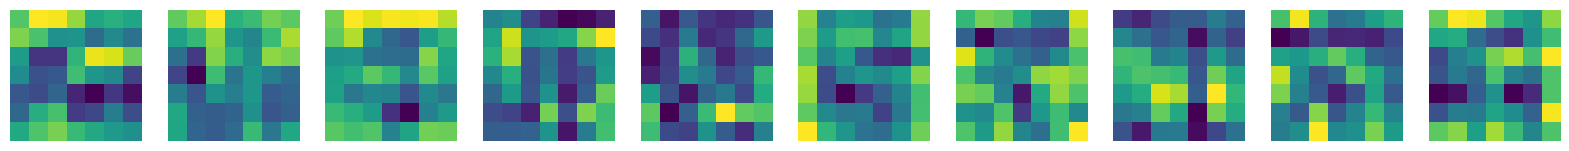

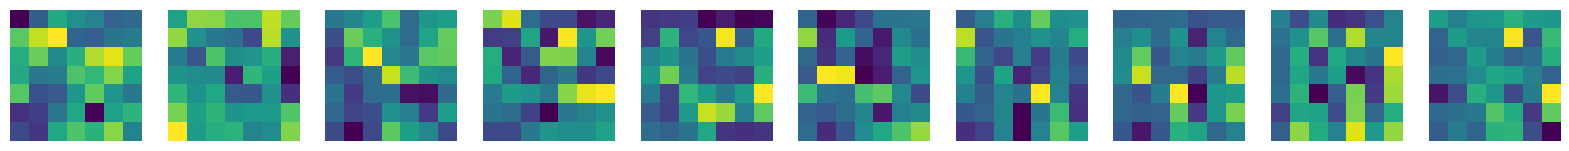

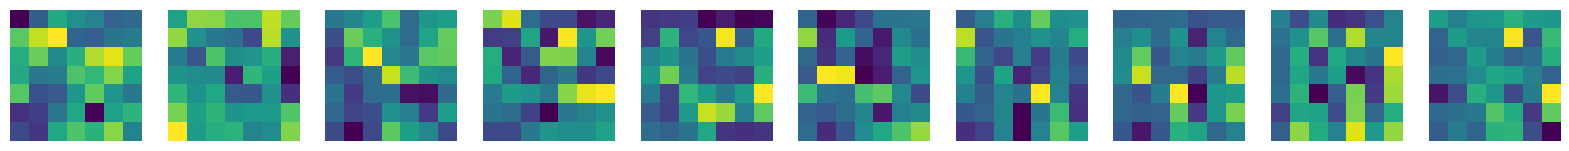

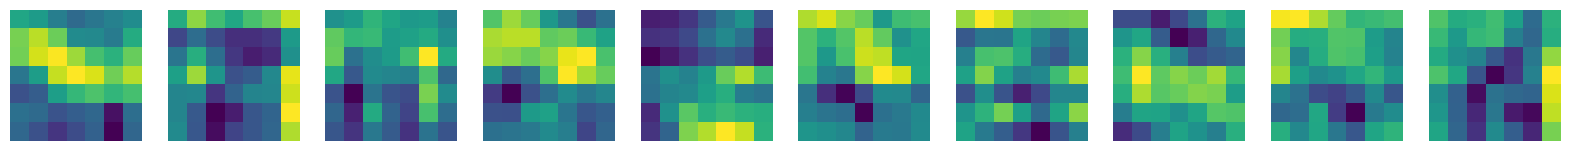

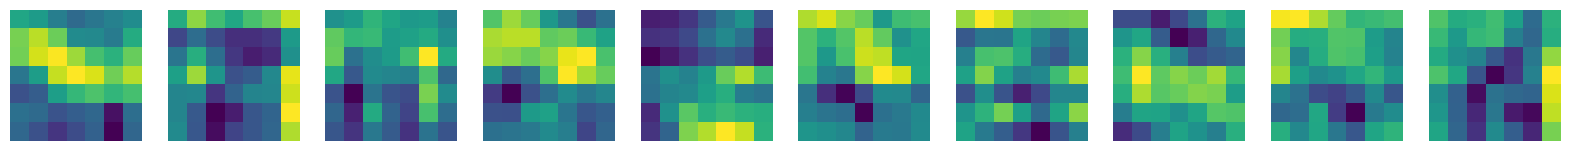

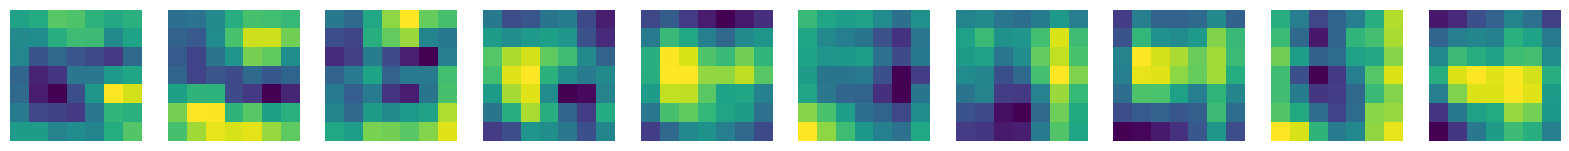

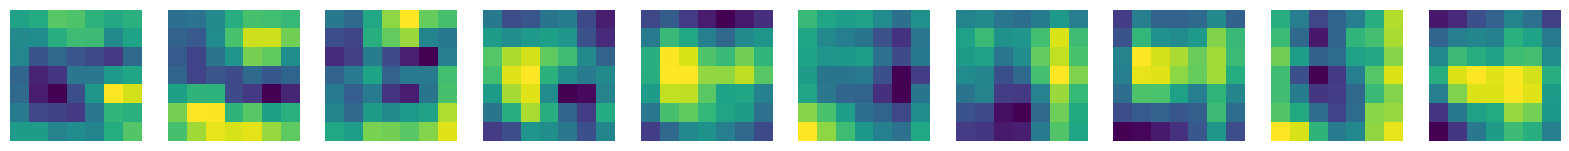

In [23]:
example_image = horse  # Load your image here and preprocess it
example_image = example_image.to(torch.device('cpu'))

model = model.to(torch.device('cpu'))
model.eval()

# Initialize a list to store feature maps
feature_maps = []

# Hook function to capture intermediate outputs
def hook_fn(module, input, output):
    feature_maps.append(output)

# Register the hook for all convolutional layers
for layer in model.modules():
    if isinstance(layer, nn.Conv2d):
        layer.register_forward_hook(hook_fn)

with torch.no_grad():
    model(example_image.unsqueeze(0))  # Add batch dimension

# Visualize captured feature maps
for layer_idx, feature_map in enumerate(feature_maps):
    
    num_feature_maps = min(10, feature_map.size(1))  # Ensure only up to 10 feature maps are shown

    fig, axs = plt.subplots(1, num_feature_maps, figsize=(20, 5))

    for i in range(num_feature_maps):
        fmap = feature_map[0, i].cpu().detach().numpy()
        axs[i].imshow(fmap, cmap='viridis')
        axs[i].axis('off')
    plt.show()